In [1]:
import pickle
import tarfile
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.feature import hog
from sklearn.metrics import precision_score
from sklearn.neighbors import NearestNeighbors


c:\Users\Bruger\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# LOAD 

In [2]:
path = r"C:\Users\Bruger\Desktop\p 7\Datasets\cifar-10-python.tar.gz"

In [3]:
# Path to the tar.gz file you downloaded
tar_path = path

# Extract the tar.gz file
with tarfile.open(tar_path, 'r:gz') as tar:
    tar.extractall(path="path/to/extract")

# Define the path where CIFAR-10 was extracted
data_dir = 'path/to/extract/cifar-10-batches-py/'

# Function to unpickle the dataset
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Load all the training batches

# Modified function to load a subset of CIFAR-10 data
def load_cifar10_data(data_dir, subset_size=None):
    train_data = []
    train_labels = []
    
    # Load the training batches (5 batches)
    for i in range(1, 6):
        batch_path = os.path.join(data_dir, f'data_batch_{i}')
        batch = unpickle(batch_path)
        train_data.append(batch[b'data'])
        train_labels.append(batch[b'labels'])
    
    # Combine all batches into a single array
    X_train = np.concatenate(train_data)
    y_train = np.concatenate(train_labels)
    
    # Reshape into 32x32x3 images
    X_train = X_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    
    # Load the test data
    test_batch = unpickle(os.path.join(data_dir, 'test_batch'))
    X_test = test_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    y_test = np.array(test_batch[b'labels'])
    
    # If a subset is requested
    if subset_size is not None:
        subset_size = min(subset_size, len(X_train))  # Ensure subset size is not larger than the dataset
        
        # Define the subset for training
        X_train_subset = X_train[:subset_size]
        y_train_subset = y_train[:subset_size]
        
        # Define the test subset as 1/5th of the training subset
        test_subset_size = subset_size // 5
        X_test_subset = X_test[:test_subset_size]
        y_test_subset = y_test[:test_subset_size]
        
        return X_train_subset, y_train_subset, X_test_subset, y_test_subset
    
    return X_train, y_train, X_test, y_test


# Load the CIFAR-10 dataset
X_train, y_train, X_test, y_test = load_cifar10_data(data_dir,subset_size = 600)

# Now, X_train and X_test are arrays containing the image data
# y_train and y_test contain the labels.
print(f'Training data shape: {X_train.shape}')
print(f'Test data shape: {X_test.shape}')

Training data shape: (600, 32, 32, 3)
Test data shape: (120, 32, 32, 3)


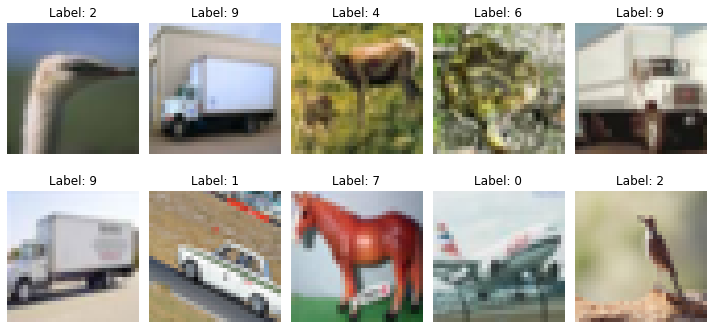

In [4]:

# Select 10 random indices from the training data
random_indices = random.sample(range(len(X_train)), 10)

# Plot 10 random images from X_train
plt.figure(figsize=(10, 5))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns
    plt.imshow(X_train[idx])
    plt.axis('off')
    plt.title(f'Label: {y_train[idx]}')  # Optionally show the label

plt.tight_layout()
plt.show()

In [5]:

# Step 1: Define HOG function to extract features
def extract_hog_features(images):
    hog_features = []
    for img in images:
        # Convert to grayscale for HOG feature extraction
        img_gray = np.dot(img[..., :3], [0.2989, 0.587, 0.114])
        features = hog(img_gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
        hog_features.append(features)
    return np.array(hog_features)

# Extract HOG features from training and test images
hog_train_features = extract_hog_features(X_train)
hog_test_features = extract_hog_features(X_test)

In [6]:
# Step 2: LSH Projection
def lsh_projection(X, num_bits):
    """
    Project the data using LSH.
    :param X: Input data (n_samples, n_features)
    :param num_bits: Number of hash bits for LSH
    :return: Hash codes
    """
    np.random.seed(42)  # For reproducibility
    random_projection = np.random.randn(X.shape[1], num_bits)
    hash_codes = np.dot(X, random_projection) > 0  # Binary hash codes
    return hash_codes.astype(int)

def perform_lsh_with_projection(X_train, X_test, num_bits=32):
    # Generate hash codes for both training and test data
    X_train_hash_codes = lsh_projection(X_train, num_bits)
    X_test_hash_codes = lsh_projection(X_test, num_bits)
    
    # Initialize nearest neighbors using Hamming distance on binary hash codes
    lsh_nn = NearestNeighbors(n_neighbors=5, metric='hamming')
    lsh_nn.fit(X_train_hash_codes)
    
    # Find the nearest neighbors
    neighbors = lsh_nn.kneighbors(X_test_hash_codes, return_distance=False)
    
    return neighbors, X_train_hash_codes, X_test_hash_codes

# Step 3: Calculate precision at k for LSH
def compute_precision_at_k(lsh_neighbors, y_train, y_test, k):
    precisions = []
    for i in range(1, k + 1):
        top_k_neighbors = lsh_neighbors[:, :i]
        y_pred = np.array([np.bincount(y_train[neighbors]).argmax() for neighbors in top_k_neighbors])
        precision = precision_score(y_test, y_pred, average='macro')
        precisions.append(precision)
    return precisions

In [7]:
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

# Perform LSH with raw pixel data
lsh_neighbors_raw, X_train_hash_raw, X_test_hash_raw = perform_lsh_with_projection(X_train_flat, X_test_flat, num_bits=32)

# Perform LSH with HOG features
lsh_neighbors_hog, X_train_hash_hog, X_test_hash_hog = perform_lsh_with_projection(hog_train_features, hog_test_features, num_bits=32)

# Compute precision for raw pixel data
precisions_raw = compute_precision_at_k(lsh_neighbors_raw, y_train, y_test, k=50)

# Compute precision for HOG features
precisions_hog = compute_precision_at_k(lsh_neighbors_hog, y_train, y_test, k=50)


c:\Users\Bruger\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
np.mean(X_train_hash_raw)

0.52890625

In [9]:
k_values = list(range(50))

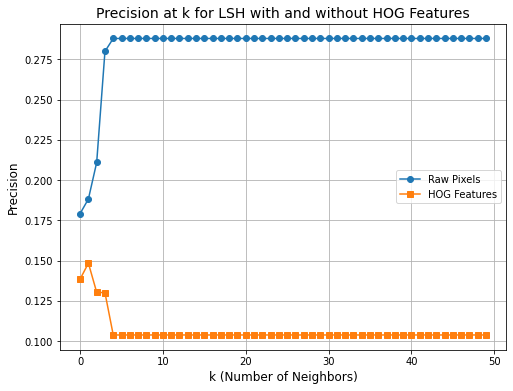

In [10]:

# Plot precision for raw pixels and HOG features
plt.figure(figsize=(8, 6))
plt.plot(k_values, precisions_raw, label="Raw Pixels", marker='o')
plt.plot(k_values, precisions_hog, label="HOG Features", marker='s')

# Add labels and title
plt.xlabel("k (Number of Neighbors)", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision at k for LSH with and without HOG Features", fontsize=14)

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()

In [11]:
def map(train_hashes, test_hashes, train_labels, test_labels):
    """
    Compute Mean Average Precision (MAP) for LSH using binary hash codes.
    
    :param train_hashes: Binary hash codes of training set (n_train, num_bits)
    :param test_hashes: Binary hash codes of test set (n_test, num_bits)
    :param train_labels: Labels for training set (n_train,)
    :param test_labels: Labels for test set (n_test,)
    :return: Mean Average Precision (MAP) value
    """
    num_test = test_hashes.shape[0]
    num_train = train_hashes.shape[0]
    
    # Initialize a list to store the average precision for each test sample
    ap_list = []

    # Compute Hamming distance between test hashes and all train hashes
    for i in range(num_test):
        test_hash = test_hashes[i]
        
        # Compute Hamming distance between current test hash and all training hashes
        hamming_distances = np.sum(np.abs(train_hashes - test_hash), axis=1)
        
        # Sort indices by Hamming distance (closer hashes first)
        sorted_indices = np.argsort(hamming_distances)
        
        # Retrieve sorted labels based on Hamming distance
        sorted_train_labels = train_labels[sorted_indices]
        
        # Compute precision at each rank position
        relevant_retrieved = 0
        precision_sum = 0
        total_relevant = np.sum(test_labels[i] == train_labels)
        
        if total_relevant == 0:
            continue  # Skip if no relevant items in the training set for this test sample
        
        for rank, label in enumerate(sorted_train_labels, 1):
            if label == test_labels[i]:
                relevant_retrieved += 1
                precision_at_rank = relevant_retrieved / rank
                precision_sum += precision_at_rank
        
        # Average precision for this test sample
        ap = precision_sum / total_relevant
        ap_list.append(ap)
    
    # Compute MAP as the mean of all average precisions
    map_value = np.mean(ap_list) if len(ap_list) > 0 else 0
    return map_value


In [12]:
z = map(X_train_hash_raw,X_test_hash_raw,y_train,y_test)
x = map(X_train_hash_hog,X_test_hash_hog,y_train,y_test)

In [13]:
print(z)

0.1325775572638912


In [14]:
print(x)

0.12334060578278651


In [15]:
# Use LSH 

# Classification example

In [16]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from skimage.feature import hog
import tensorflow as tf

c:\Users\Bruger\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:150: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Bruger\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 245, in _count_physical_cores
    raise ValueError(


Accuracy with raw pixel data: 0.2417
Accuracy with HOG features: 0.2833


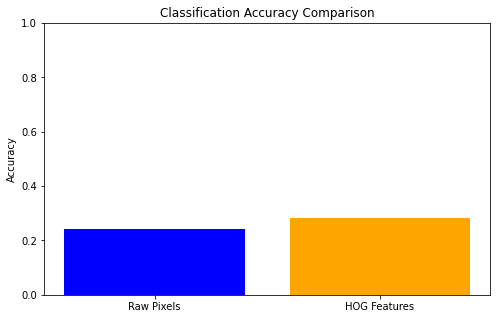

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

# Assuming X_train, X_test, y_train, y_test are already defined
# e.g., X_train, y_train, X_test, y_test = load_cifar_data(subset=True)

# Extract HOG features
def extract_hog_features(X):
    hog_features = []
    for img in X:
        feature = hog(img, pixels_per_cell=(4, 4), cells_per_block=(2, 2), orientations=9, block_norm='L2-Hys', visualize=False)
        hog_features.append(feature)
    return np.array(hog_features)

# Prepare raw pixel data
X_train_raw = X_train.reshape(len(X_train), -1)  # Flatten the images
X_test_raw = X_test.reshape(len(X_test), -1)

# Prepare HOG features
X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

# Standardizing features for better performance
scaler = StandardScaler()
X_train_raw = scaler.fit_transform(X_train_raw)
X_test_raw = scaler.transform(X_test_raw)
X_train_hog = scaler.fit_transform(X_train_hog)
X_test_hog = scaler.transform(X_test_hog)

# Initialize classifiers
knn_raw = KNeighborsClassifier(n_neighbors=50)
knn_hog = KNeighborsClassifier(n_neighbors=50)

# Train classifiers
knn_raw.fit(X_train_raw, y_train)
knn_hog.fit(X_train_hog, y_train)

# Make predictions
y_pred_raw = knn_raw.predict(X_test_raw)
y_pred_hog = knn_hog.predict(X_test_hog)

# Evaluate performance
accuracy_raw = accuracy_score(y_test, y_pred_raw)
accuracy_hog = accuracy_score(y_test, y_pred_hog)

print(f"Accuracy with raw pixel data: {accuracy_raw:.4f}")
print(f"Accuracy with HOG features: {accuracy_hog:.4f}")

# Optional: Plotting the accuracy comparison
labels = ['Raw Pixels', 'HOG Features']
accuracies = [accuracy_raw, accuracy_hog]

plt.figure(figsize=(8, 5))
plt.bar(labels, accuracies, color=['blue', 'orange'])
plt.ylabel('Accuracy')
plt.title('Classification Accuracy Comparison')
plt.ylim(0, 1)
plt.show()


# VGG test

1/1 [==============================] - 0s 217ms/step
k-NN Classifier:
Accuracy with raw pixel data: 0.1583, F1 Score: 0.1392
Accuracy with HOG features: 0.2833, F1 Score: 0.2531

Logistic Regression Classifier:
Accuracy with raw pixel data: 0.2750, F1 Score: 0.2709
Accuracy with HOG features: 0.2750, F1 Score: 0.2742
Accuracy with VGG16 features: 0.6917, F1 Score: 0.6833


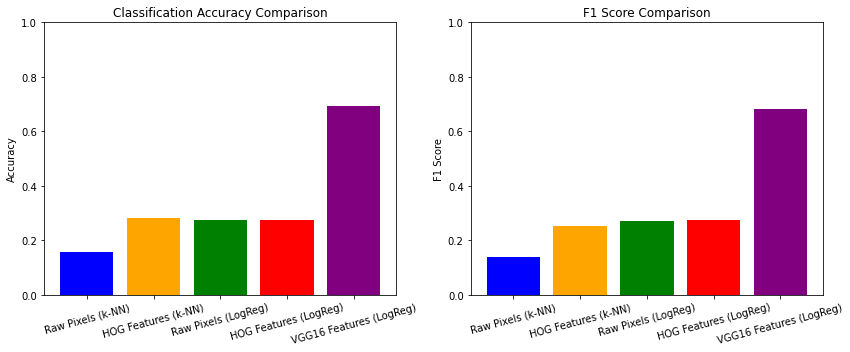

In [18]:

# Pre-trained VGG16 model for feature extraction
def extract_vgg16_features(X):
    model = VGG16(weights='imagenet', include_top=False, pooling='avg')  # Exclude top layers
    feature_list = []
    
    for img in X:
        img = img_to_array(img)  # Convert image to array
        img = tf.image.resize(img, (224, 224))  # Resize to VGG input size
        img = np.expand_dims(img, axis=0)  # Add batch dimension
        features = model.predict(img)  # Get features from VGG16
        feature_list.append(features.flatten())
    
    return np.array(feature_list)

# Extract features from the raw pixel data using VGG16
X_train_vgg = extract_vgg16_features(X_train)
X_test_vgg = extract_vgg16_features(X_test)

# Extract HOG features
X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

# Standardizing features for better performance
scaler = StandardScaler()
X_train_raw = scaler.fit_transform(X_train_raw)
X_test_raw = scaler.transform(X_test_raw)
X_train_hog = scaler.fit_transform(X_train_hog)
X_test_hog = scaler.transform(X_test_hog)
X_train_vgg = scaler.fit_transform(X_train_vgg)
X_test_vgg = scaler.transform(X_test_vgg)

# Initialize classifiers
knn_raw = KNeighborsClassifier(n_neighbors=5)
knn_hog = KNeighborsClassifier(n_neighbors=5)
logreg_raw = LogisticRegression(max_iter=1000)
logreg_hog = LogisticRegression(max_iter=1000)
logreg_vgg = LogisticRegression(max_iter=1000)

# Train classifiers
knn_raw.fit(X_train_raw, y_train)
knn_hog.fit(X_train_hog, y_train)
logreg_raw.fit(X_train_raw, y_train)
logreg_hog.fit(X_train_hog, y_train)
logreg_vgg.fit(X_train_vgg, y_train)

# Make predictions
y_pred_raw_knn = knn_raw.predict(X_test_raw)
y_pred_hog_knn = knn_hog.predict(X_test_hog)
y_pred_raw_logreg = logreg_raw.predict(X_test_raw)
y_pred_hog_logreg = logreg_hog.predict(X_test_hog)
y_pred_vgg_logreg = logreg_vgg.predict(X_test_vgg)

# Evaluate performance
accuracy_raw_knn = accuracy_score(y_test, y_pred_raw_knn)
accuracy_hog_knn = accuracy_score(y_test, y_pred_hog_knn)
accuracy_raw_logreg = accuracy_score(y_test, y_pred_raw_logreg)
accuracy_hog_logreg = accuracy_score(y_test, y_pred_hog_logreg)
accuracy_vgg_logreg = accuracy_score(y_test, y_pred_vgg_logreg)

f1_raw_knn = f1_score(y_test, y_pred_raw_knn, average='weighted')
f1_hog_knn = f1_score(y_test, y_pred_hog_knn, average='weighted')
f1_raw_logreg = f1_score(y_test, y_pred_raw_logreg, average='weighted')
f1_hog_logreg = f1_score(y_test, y_pred_hog_logreg, average='weighted')
f1_vgg_logreg = f1_score(y_test, y_pred_vgg_logreg, average='weighted')

# Print Results
print("k-NN Classifier:")
print(f"Accuracy with raw pixel data: {accuracy_raw_knn:.4f}, F1 Score: {f1_raw_knn:.4f}")
print(f"Accuracy with HOG features: {accuracy_hog_knn:.4f}, F1 Score: {f1_hog_knn:.4f}")

print("\nLogistic Regression Classifier:")
print(f"Accuracy with raw pixel data: {accuracy_raw_logreg:.4f}, F1 Score: {f1_raw_logreg:.4f}")
print(f"Accuracy with HOG features: {accuracy_hog_logreg:.4f}, F1 Score: {f1_hog_logreg:.4f}")
print(f"Accuracy with VGG16 features: {accuracy_vgg_logreg:.4f}, F1 Score: {f1_vgg_logreg:.4f}")

# Optional: Plotting the accuracy comparison
labels = ['Raw Pixels (k-NN)', 'HOG Features (k-NN)', 
          'Raw Pixels (LogReg)', 'HOG Features (LogReg)', 
          'VGG16 Features (LogReg)']
accuracies = [
    accuracy_raw_knn, accuracy_hog_knn, 
    accuracy_raw_logreg, accuracy_hog_logreg, 
    accuracy_vgg_logreg
]

f1_scores = [
    f1_raw_knn, f1_hog_knn, 
    f1_raw_logreg, f1_hog_logreg, 
    f1_vgg_logreg
]

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(labels, accuracies, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.ylabel('Accuracy')
plt.title('Classification Accuracy Comparison')
plt.ylim(0, 1)
plt.xticks(rotation=15)

# Plot F1 Scores
plt.subplot(1, 2, 2)
plt.bar(labels, f1_scores, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison')
plt.ylim(0, 1)
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()

In [25]:
X_train_vgg.shape

(600, 512)

In [26]:
import numpy as np

# Assuming X_train_vgg and y_train are already defined (from previous code)
# You can define the map function as before

def lsh_projection(X, num_bits):
    """Project the data using LSH."""
    np.random.seed(42)  # For reproducibility
    random_projection = np.random.randn(X.shape[1], num_bits)
    hash_codes = np.dot(X, random_projection) > 0  # Binary hash codes
    return hash_codes.astype(int)

def random_projection_hash(X, num_bits):
    """Generate hash codes using random projections."""
    return lsh_projection(X, num_bits)

def binary_hash(X, threshold=0):
    """Generate hash codes using a simple thresholding method."""
    return (X > threshold).astype(int)

# Number of bits for hashing
num_bits = 32

# Generate hash codes using different techniques
hash_train_1 = lsh_projection(X_train_vgg, num_bits)  # LSH Hashing
hash_test_1 = lsh_projection(X_test_vgg,num_bits)
hash_train_2 = random_projection_hash(X_train_vgg,num_bits)
hash_test_2 =  random_projection_hash(X_train_vgg,num_bits)
hash_train_3 = binary_hash(X_train_vgg.mean(axis =1).reshape(-1,1),threshold=0.5)
hash_test_3 = binary_hash(X_test_vgg.mean(axis =1).reshape(-1,1),threshold=0.5)
#Evaluate each technique using the MAP function


In [27]:

map_lsh = map(hash_train_1,hash_test_1,y_train,y_test)
#map_random_proj = map(hash_train_2,hash_test_2,y_train,y_test)
map_binary = map(hash_train_3,hash_test_3,y_train,y_test)

# Print results
print(f"Mean Average Precision (MAP) for LSH: {map_lsh}")
#print(f"Mean Average Precision (MAP) for Random Projection: {map_random_proj:.4f}")
print(f"Mean Average Precision (MAP) for Binary Hashing: {map_binary:.4f}")


Mean Average Precision (MAP) for LSH: 0.17059483627360642
Mean Average Precision (MAP) for Binary Hashing: 0.1088


# Spectral

In [28]:
nbrs = NearestNeighbors(n_neighbors=50).fit(X_train_vgg)

# Find the nearest neighbors
distances, indices = nbrs.kneighbors(X_train_vgg)

# Create an adjacency matrix
n_samples = X_train_vgg.shape[0]
adjacency_matrix = np.zeros((n_samples, n_samples))

# Populate the adjacency matrix
for i, neighbors in enumerate(indices):
    for neighbor in neighbors:
        adjacency_matrix[i, neighbor] = 1
        adjacency_matrix[neighbor, i] = 1  # Ensure symmetry for an undirected graph



#